# Use of Fatal Force by the US Police

In the United States, use of deadly force by police has been a high-profile and contentious issue. 1000 people are shot and killed by US cops each year. The ever-growing argument is that the US has a flawed Law Enforcement system that costs too many innocent civilians their lives. In this project, we will analyze one of America’s hottest political topics, which encompasses issues ranging from institutional racism to the role of Law Enforcement personnel in society.

We will use 5 data sets in this study. Four of them describes demographics of cities in the US (city data sets) while the remaining one records the fatal incidents (police data set).

In [107]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

## Data Preprocessing

In [95]:
education = pd.read_csv('data\education.csv', encoding = "ISO-8859-1")
income = pd.read_csv('data\income.csv', encoding = "ISO-8859-1")
poverty = pd.read_csv('data\poverty.csv', encoding = "ISO-8859-1")
race = pd.read_csv('data\share_race_by_city.csv', encoding = "ISO-8859-1")
test = pd.read_csv('data\police_killings_test.csv', encoding = "ISO-8859-1")
train = pd.read_csv('data\police_killings_train.csv', encoding = "ISO-8859-1")

We first inspect and clean null data.

In [96]:
test.isnull().sum()

id                           0
name                         0
date                         0
manner_of_death              0
armed                        3
age                         40
gender                       0
race                       104
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        38
body_camera                  0
dtype: int64

Also look for invalid values.

In [97]:
# education has '-' as numbers

### Merging Counts to City Data Sets

By merging the count of fatal incident grouped by city to the city data sets, we can perform linear regression using demographics as independent variables and count as a depedent variable.

There is a discrepancy between the encoding of names between the police data set and city data sets. For example, the former refer LA in California as Los Angeles while the latter uses Los Angeles city.

We also observe that the police data set provide less information because it only has Chicago as a city, while the city data sets have Chicago city, Chicago Heights city and Chicago Ridge village. Assuming that cities bearing similar name should be geographically and demographically close to each other, we shall evenly distribute the number of fatal incidents between them.

In [98]:
# count the number of incidents grouping by city and state because city names may duplicate
city_count = train.value_counts(['city', 'state']).rename_axis(['City', 'Geographic Area']).reset_index(name='Counts')
city_count.head()

,City,Geographic Area,Counts
0,Los Angeles,CA,31
1,Phoenix,AZ,24
2,Houston,TX,22
3,Chicago,IL,21
4,Las Vegas,NV,16


In [99]:
city = education.merge(income, on=['Geographic Area', 'City']).merge(poverty, on=['Geographic Area', 'City']).merge(race, on=['Geographic Area', 'City'])
city.head()

,Geographic Area,City,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,AL,Abanda CDP,21.2,11207,78.8,67.2,30.2,0,0,1.6
1,AL,Abbeville city,69.1,25615,29.1,54.4,41.4,0.1,1,3.1
2,AL,Adamsville city,78.9,42575,25.5,52.3,44.9,0.5,0.3,2.3
3,AL,Addison town,81.4,37083,30.7,99.1,0.1,0,0.1,0.4
4,AL,Akron town,68.6,21667,42,13.2,86.5,0,0,0.3


In [100]:
def merge_count(record):
    # find record(s) matching both name and state
    match_city = city_total['City'].str.startswith(record['City'])
    match_state = city_total['Geographic Area'] == record['Geographic Area']
    match_both = np.logical_and(match_city, match_state)
    # count the number of True
    length = np.count_nonzero(match_both)
    if length == 1:     # if unique
        city_total.loc[match_both, 'Counts'] = record['Counts']
    elif length > 1:    # if multiple, take average
        count = record['Counts']/length
        city_total.loc[match_both, 'Counts'] = count

city_total = city.copy()    # changes to city_total will not affect city
city_total['Counts'] = 0
city_count.apply(merge_count, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
1276    None
1277    None
1278    None
1279    None
1280    None
Length: 1281, dtype: object

In [101]:
city_total.sort_values(by='Counts', ascending=False).head()

,Geographic Area,City,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic,Counts
2701,CA,Los Angeles city,75.5,50205,22.1,49.8,9.6,0.7,11.3,48.5,31.0
1198,AZ,Phoenix city,80.7,47326,23.1,65.9,6.5,2.2,3.2,40.8,24.0
25036,TX,Houston city,76.7,46187,22.5,50.5,23.7,0.7,6,43.8,22.0
15596,NV,Las Vegas city,83.3,50202,17.5,62.1,11.1,0.7,6.1,31.5,16.0
25744,TX,San Antonio city,81.4,46744,19.8,72.6,6.9,0.9,2.4,63.2,15.0


### Merging City Data Sets to the Police Data Set

By merging the city demographics to the police data set, we can append background information to each of the incident. In this study, we will use various city demographics as independent variables to predict the race of victim.

In [102]:
fields = ['percent_completed_hs', 'Median Income', 'poverty_rate', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']

def merge_city(record):
    # find record(s) matching both name and state
    match_city = city['City'].str.startswith(record['city'])
    match_state = city['Geographic Area'] == record['state']
    match_both = np.logical_and(match_city, match_state)
    match = city.loc[match_both]
    # assign the mean of city demographics to the police data set
    for field in fields:
        record.loc[field] = pd.to_numeric(match[field], errors='coerce').mean()
    return record[fields]

train[fields] = train.apply(merge_city, axis=1)

In [103]:
train.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,...,flee,body_camera,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,3,Tim Elliot,02/01/15,shot,gun,53.0,M,A,Shelton,WA,...,Not fleeing,False,80.1,37072.0,28.6,78.9,0.8,3.7,1.1,19.2
1,4,Lewis Lee Lembke,02/01/15,shot,gun,47.0,M,W,Aloha,OR,...,Not fleeing,False,88.1,65765.0,14.9,70.9,2.6,1.0,8.9,21.1
2,5,John Paul Quintero,03/01/15,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,...,Not fleeing,False,87.5,45947.0,17.3,71.9,11.5,1.2,4.8,15.3
3,8,Matthew Hoffman,04/01/15,shot,toy weapon,32.0,M,W,San Francisco,CA,...,Not fleeing,False,87.0,81294.0,13.2,48.5,6.1,0.5,33.3,15.1
4,9,Michael Rodriguez,04/01/15,shot,nail gun,39.0,M,H,Evans,CO,...,Not fleeing,False,76.3,47791.0,16.6,76.5,0.9,1.2,0.9,43.1


### Recoding Features

There are too many unique values for the column armed. Since we only study whether the victim is armed or not, we can convert all values other than 'unarmed' and 'undetermined' to 'armed'.

In [104]:
train['armed'].value_counts()

gun                                 1114
knife                                304
unarmed                              148
vehicle                              125
undetermined                          91
                                    ... 
bean-bag gun                           1
baseball bat and fireplace poker       1
straight edge razor                    1
hand torch                             1
pole and knife                         1
Name: armed, Length: 65, dtype: int64

In [105]:
train['armed'].where(np.logical_or(train['armed'] == 'unarmed', train['armed'] == 'undetermined'), 'armed', inplace=True)
train['armed'].value_counts()

armed           1789
unarmed          148
undetermined      91
Name: armed, dtype: int64

We use label encoder from scikit-learn to encode categorical features.

In [108]:
encoder = LabelEncoder()
fields = ['manner_of_death', 'armed', 'gender', 'signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']
for field in fields:
    transformed = encoder.fit_transform(train[field].astype(str))
    #ohe_df = pd.Series(transformed)
    #train = pd.concat([train, ohe_df], axis=1).drop([field], axis=1)
    train[field] = pd.Series(transformed)

We use label binarizer from scikit-learn to one-hot encode label.

In [114]:
encoder = LabelBinarizer()
transformed = encoder.fit_transform(train['race'].astype(str))

We can proceed to separate the independent and the dependent variables in the data set. We can also eliminate columns that are irrelevant to the study. 

In [115]:
x_train = train.drop(columns=['id', 'name', 'race', 'date'])
y_train = pd.DataFrame(transformed)

In [117]:
x_train.head()

,manner_of_death,armed,age,gender,city,state,signs_of_mental_illness,threat_level,flee,body_camera,percent_completed_hs,Median Income,poverty_rate,share_white,share_black,share_native_american,share_asian,share_hispanic
0,0,0,53.0,1,Shelton,WA,1,0,2,0,80.1,37072.0,28.6,78.9,0.8,3.7,1.1,19.2
1,0,0,47.0,1,Aloha,OR,0,0,2,0,88.1,65765.0,14.9,70.9,2.6,1.0,8.9,21.1
2,1,1,23.0,1,Wichita,KS,0,1,2,0,87.5,45947.0,17.3,71.9,11.5,1.2,4.8,15.3
3,0,0,32.0,1,San Francisco,CA,1,0,2,0,87.0,81294.0,13.2,48.5,6.1,0.5,33.3,15.1
4,0,0,39.0,1,Evans,CO,0,0,2,0,76.3,47791.0,16.6,76.5,0.9,1.2,0.9,43.1


In [118]:
y_train.head()

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0
4,0,0,1,0,0,0,0


## Exploratory Data Analysis

We plot the columns to study the distribution of features.

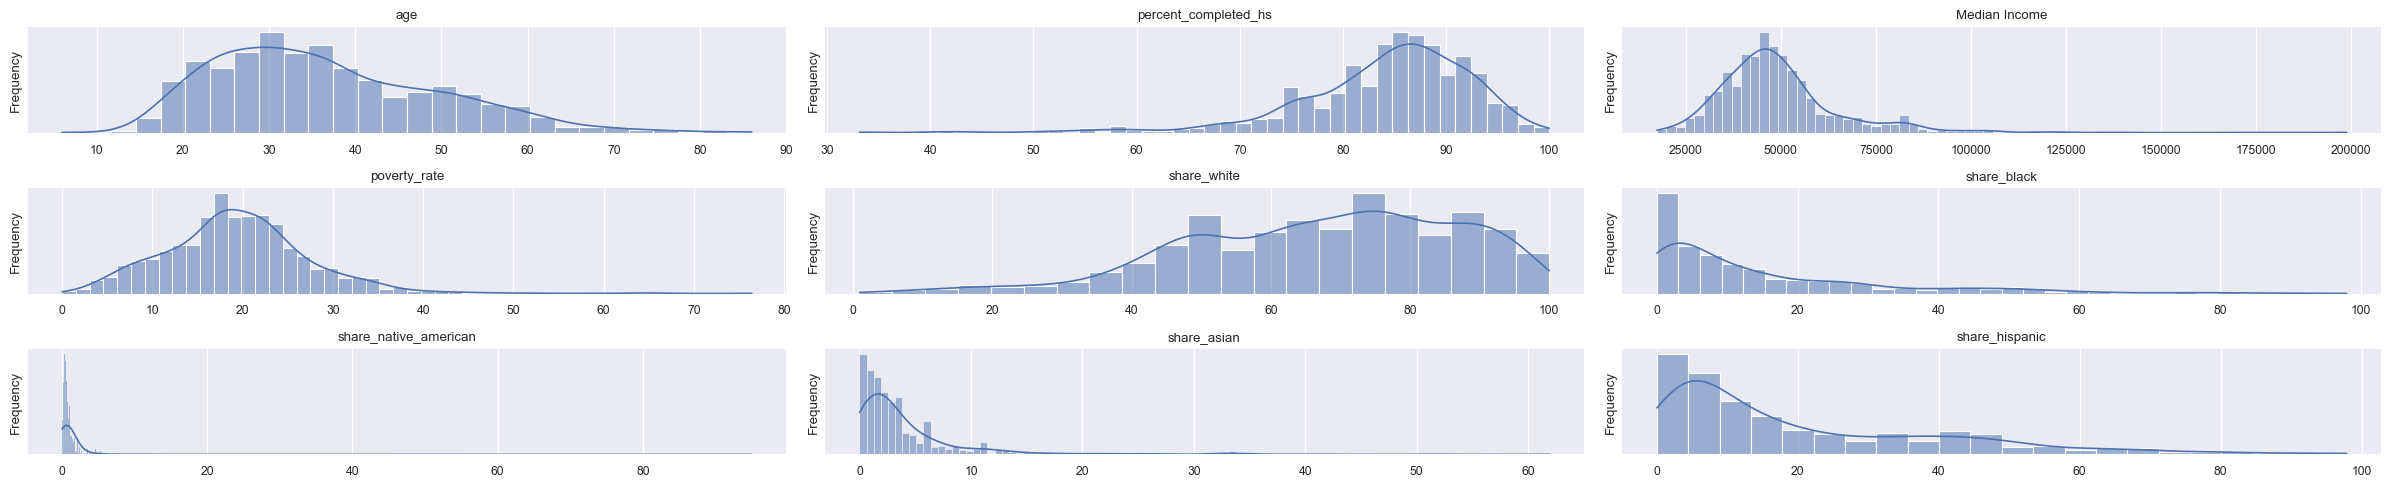

In [125]:
columns = ['age', 'percent_completed_hs', 'Median Income', 'poverty_rate', 'share_white', 'share_black', 'share_native_american', 'share_asian', 'share_hispanic']
fig = plt.figure(dpi=100, figsize=(24, 16), tight_layout=True)
sns.set_theme()
sns.set_context("paper")
for i, col in enumerate(columns):
  ax = fig.add_subplot(10, 3, i + 1)
  sns.histplot(x_train[col], kde=True)
  ax.set_title(col)
  ax.set_yticks([])
  ax.set_ylabel("Frequency")
  ax.set_xlabel(None)
  ax.tick_params(left=False, bottom=False)
  for ax, spine in ax.spines.items():
    spine.set_visible(False)

We visualise the correlation of columns with a heatmap.

<AxesSubplot:>

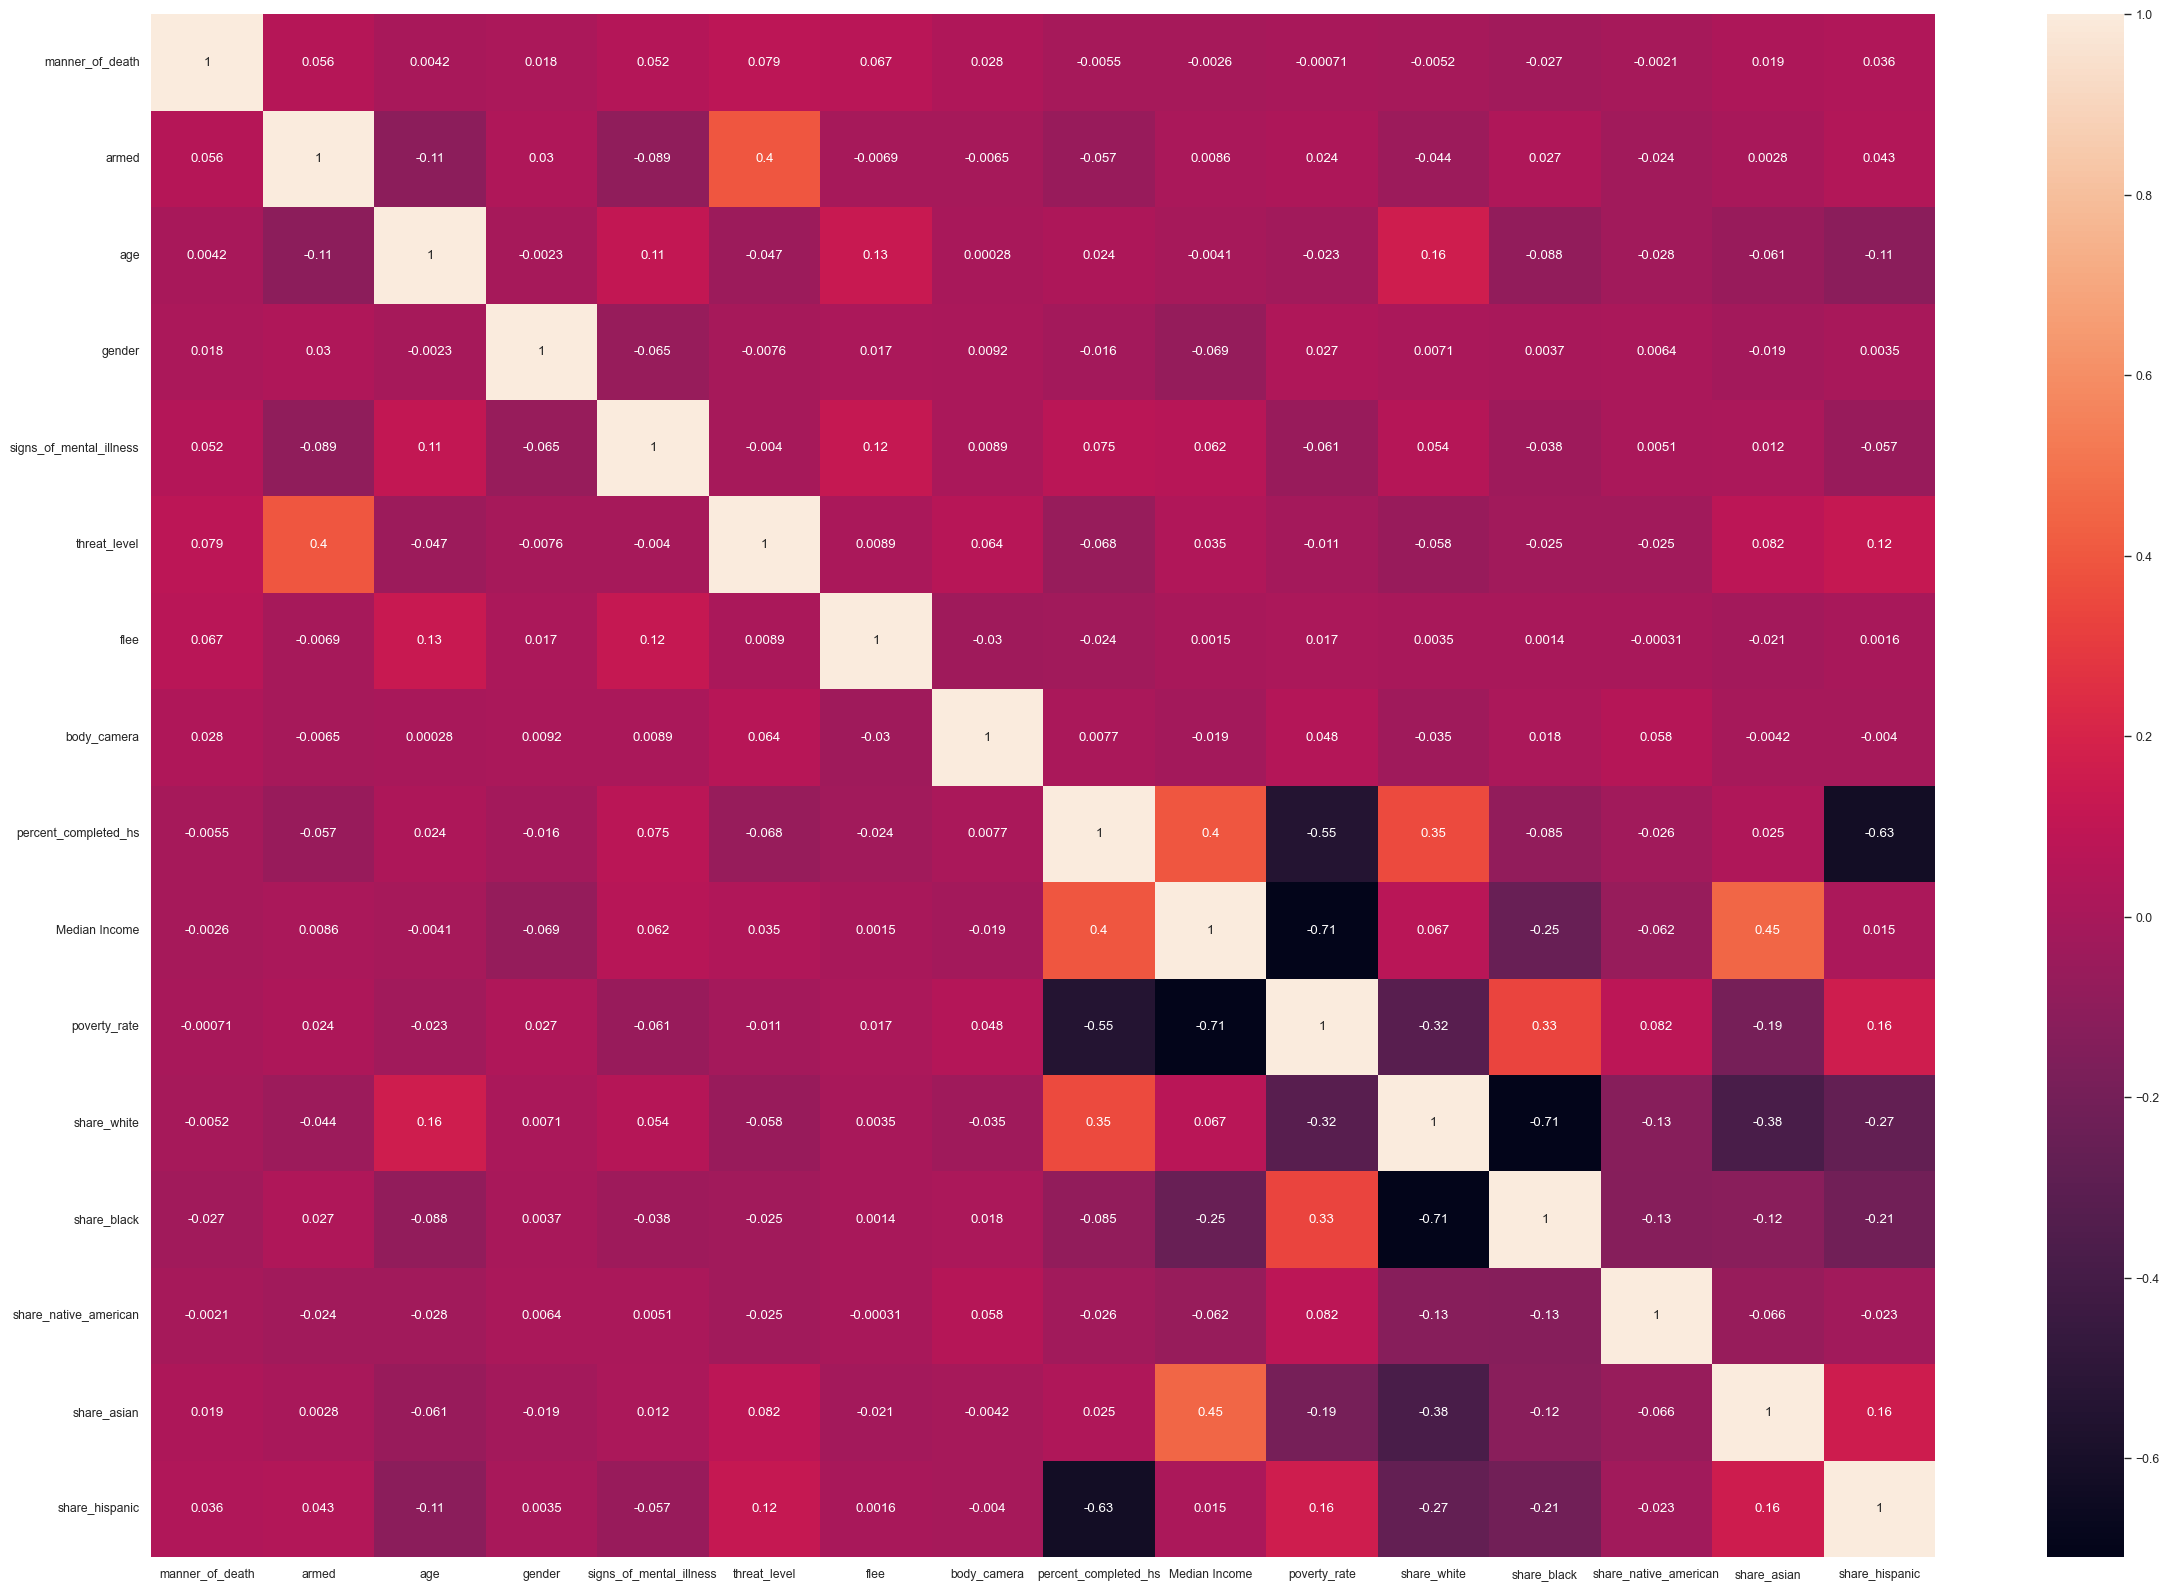

In [126]:
fig = plt.figure(dpi=100, figsize=(24, 16), tight_layout=True)
corr = x_train.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True)

# Linear Regression

We hypothesizes that lower the white people share, higher the fatal count.